<a href="https://colab.research.google.com/github/yyc0314/DQN_atari_breakout/blob/main/DQN_breakout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget http://www.atarimania.com/roms/Roms.rar
!mkdir /content/ROM/
!unrar e /content/Roms.rar /content/ROM/
!python -m atari_py.import_roms /content/ROM/
!pip install atari-py==0.2.6
!pip install gym==0.21.0
!pip install gym[atari]

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

##一般RL的運作方式

```
state=env.reset() #初始化
while True:
  action=choose_action(state) #RL演算法
  state_next,reward,done,infor=env.step(action) #done->是否結束 info->除了state以外的其他資訊
  env.render() #有些遊戲可以將畫面渲染出來
  state=state_next.copy() 更新狀態
  if done:
    break
```



In [ ]:
env_name = "ALE/Breakout-v5"
env = gym.make(env_name)

1
0.0 False False {'lives': 5, 'episode_frame_number': 4, 'frame_number': 4}


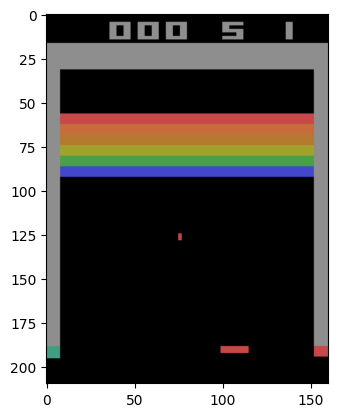

In [ ]:
'''print("environment:", env_name)
print("action space:", env.action_space.n) #有幾個動作
print("action:", env.unwrapped.get_action_meanings()) #動作的意義
print("observation space:", env.observation_space.shape)
'''
state,_ = env.reset()
action = env.action_space.sample()
print(action)
state_next, reward,ter,tru,info = env.step(1)
print(reward, ter,tru, info)
plt.figure()
plt.imshow(state_next)

In [ ]:
class BreakEnvWrapper(gym.Wrapper):
  def __init__(self,env,k,img_size=(84,84)):
    gym.Wrapper.__init__(self,env)
    self.k=k
    self.img_size=img_size
    obs_shape=env.observation_space.shape
    self.observation_space=gym.spaces.Box(low=0.0,high=1.0,shape=(k,img_size[0],img_size[1]),dtype=np.float32)

  def _preprocess(self,state,th=0.26):
    state=np.array(Image.fromarray(state).resize(self.img_size,Image.BILINEAR)) #resize
    state=state.astype(np.float64).mean(2)/255. #第三維(2 RGB)平均/255 轉灰階
    return state

  #疊加前後幀 動態上的變化
  def reset(self):
    state,_=self.env.reset()
    state=self._preprocess(state)
    state=state[np.newaxis,...].repeat(self.k,axis=0) #複製k份疊加
    return state

  #以防在k步期間遊戲就結束了
  def step(self,action):
    state_next=[]
    info=[]
    reward=0 #整個frame的大reward
    ter=False
    for i in range(self.k):
      if not ter:
        state_next_f,reward_f,ter_f,tru_f,info_f=self.env.step(action)
        state_next_f=self._preprocess(state_next_f)
        reward+=reward_f
        ter=ter_f
        info.append(info_f)
        #print("h1",type(state_next_f))
      state_next.append(state_next_f[np.newaxis,...])
    state_next=np.concatenate(state_next,0) #疊起來
    #print(type(state_next))

    return state_next,reward,ter,tru,info

observation space: (4, 84, 84)
(84, 84)


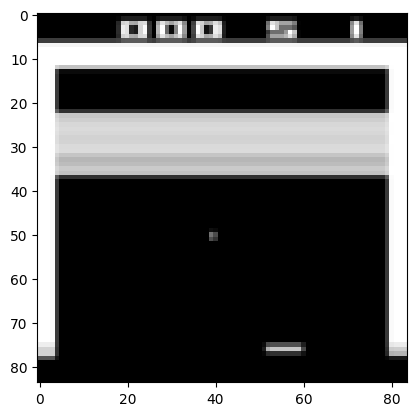

In [ ]:
env_break=BreakEnvWrapper(env,k=4,img_size=(84,84)) #k=4 -> 疊加4個frames
print("observation space:",env_break.observation_space.shape)

state=env_break.reset()
action=env_break.action_space.sample()
state_next, reward, ter,tru, info = env_break.step(1)
print(state_next[1].shape)
plt.imshow(state_next[0],cmap="gray")

In [ ]:
class QNet(nn.Module):
  def __init__(self,input_shape,n_actions):
    super(QNet,self).__init__()
    self.conv=nn.Sequential(
        nn.Conv2d(input_shape[0],32,kernel_size=8,stride=4),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=4,stride=2),
        nn.ReLU(),
        nn.Conv2d(64,64,kernel_size=3,stride=1),
        nn.ReLU(),
    )
    conv_out_size=self._get_conv_out(input_shape)

    self.fc=nn.Sequential(
        nn.Flatten(),
        nn.Linear(conv_out_size,512),
        nn.ReLU(),
        nn.Linear(512,n_actions),

    )
  def _get_conv_out(self,shape):
    o=self.conv(torch.zeros(1,*shape))
    return int(np.prod(o.size())) #output的size算出最後一層conv的輸出大小

  def forward(self,x):
    conv_out=self.conv(x)
    out=self.fc(conv_out)
    return out

In [ ]:
date_old="50203"
date_new="50303"

In [ ]:
path_td="breakout/gif/png/tdloss_"+date_new+".png"
path_re="breakout/gif/png/rw_"+date_new+".png"
path_t_re="breakout/gif/png/t_rw_"+date_new+".png"

path_npy_old="breakout/gif/save/"+date_old #舊的(跟接著訓練的qnet同個檔名)
path_npy_new="breakout/gif/save/"+date_new #新的(此次訓練的檔名)

import os
if not os.path.exists(path_npy_new):
  os.makedirs(path_npy_new)

In [ ]:
class DeepQNetwork():
  def __init__(
    self,
    n_actions,
    input_shape,
    qnet,
    device,
    learning_rate = 2e-4,
    reward_decay = 0.99,
    replace_target_iter = 5000,
    memory_size = 200000, ###
    batch_size = 32,
  ):
    # initialize
    self.losses = [] #
    self.aver_l = [] #
    self.rewards = [] #
    self.aver_r = []  #
    self.t_r = [] #

    self.n_actions = n_actions
    self.input_shape = input_shape
    self.lr = learning_rate
    self.gamma = reward_decay
    self.replace_target_iter = replace_target_iter
    self.memory_size = memory_size
    self.batch_size = batch_size
    self.device = device
    self.learn_step_counter = 0
    self.init_memory()

    self.png_size=100000

    self.png_index= len(self.memory["aver_td"]) #

    self.qnet_eval=qnet(self.input_shape,self.n_actions).to(self.device)
    self.qnet_target=qnet(self.input_shape,self.n_actions).to(self.device)
    self.qnet_target.eval()
    self.optimizer=optim.RMSprop(self.qnet_eval.parameters(),lr=self.lr)

  def choose_action(self, state, epsilon=0):
    state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
    actions_value = self.qnet_eval.forward(state)
    if np.random.uniform(0,1) > epsilon:   # greedy
      action=torch.max(actions_value,1)[1].data.cpu().numpy()[0]
    else:   # random
      action=np.random.randint(0, self.n_actions)
    return action

  def learn(self): #根據我們的資料取一個batch來訓練
    if self.learn_step_counter % self.replace_target_iter==0: #特定步數後更新
      self.qnet_target.load_state_dict(self.qnet_eval.state_dict())

    if self.memory_counter > self.memory_size:
      sample_index=np.random.choice(self.memory_size,size=self.batch_size)
    else:
      sample_index=np.random.choice(self.memory_counter,size=self.batch_size)

    b_s = torch.FloatTensor(self.memory["s"][sample_index]).to(self.device)
    b_a = torch.LongTensor(self.memory["a"][sample_index]).to(self.device)
    b_r = torch.FloatTensor(self.memory["r"][sample_index]).to(self.device)
    b_s_ = torch.FloatTensor(self.memory["s_"][sample_index]).to(self.device)
    b_d = torch.FloatTensor(self.memory["done"][sample_index]).to(self.device)

    q_curr_eval = self.qnet_eval(b_s).gather(1,b_a)
    q_next_target = self.qnet_target(b_s_).detach()

    #next_state_values = q_next_target.max(1)[0].view(-1, 1)   # DQN
    q_next_eval = self.qnet_eval(b_s_).detach()
    next_state_values = q_next_target.gather(1, q_next_eval.max(1)[1].unsqueeze(1))   # DDQN
                #1-b_d if b_d==1(done)就沒有下一個值
    q_curr_recur = b_r + (1-b_d) * self.gamma * next_state_values

    self.loss = F.smooth_l1_loss(q_curr_eval, q_curr_recur)
    self.optimizer.zero_grad()
    self.loss.backward()
    self.optimizer.step()
    self.learn_step_counter += 1
    self.losses.append(self.loss.detach().cpu().numpy())

    return self.loss.detach().cpu().numpy()

  def init_memory(self): #初始化 replayed buffer
    if not hasattr(self, "memory"):
      self.memory={
        "s":np.zeros((self.memory_size,*self.input_shape)),
        "a":np.zeros((self.memory_size,1)),
        "r":np.zeros((self.memory_size,1)),
        "s_":np.zeros((self.memory_size,*self.input_shape)),
        "done":np.zeros((self.memory_size,1)),

        "aver_td":[],
        "aver_re":[],
        "total_re":[],
    }

  def store_transition(self,s,a,r,s_,d): #儲存進memory
    if not hasattr(self,"memory_counter"): #memory大小限制 初始化
      self.memory_counter=0
    if self.memory_counter <= self.memory_size: #當超過memory_size，重頭存
      index=self.memory_counter % self.memory_size
    else:
      index=np.random.randint(self.memory_size)

    self.memory["s"][index]=s
    self.memory["a"][index]=np.array(a).reshape(-1,1)
    self.memory["r"][index]=np.array(r).reshape(-1,1)
    self.memory["s_"][index]=s_
    self.memory["done"][index]=np.array(d).reshape(-1,1)
    self.memory_counter+=1

    self.rewards.append(r)

  def store_t_r(self,total_reward):
    self.t_r.append(total_reward)
    if self.t_r:
      self.memory["total_re"] = np.concatenate([self.memory["total_re"], [self.t_r[-1]]])


  def add_r_l(self):
    r_value=self.rewards[-100:]
    aver_rv=sum(r_value)/100
    self.aver_r.append(aver_rv)

    l_value=self.losses[-100:]
    aver_lv=sum(l_value)/100
    self.aver_l.append(aver_lv)

  def store_png(self): #100存一次averange
    if not hasattr(self,"png_memory_counter"): #memory大小限制
         self.png_memory_counter=0
    if self.png_memory_counter <= self.png_size: #當超過memory_size，重頭存
        self.png_index=self.png_memory_counter % self.png_size

    self.add_r_l()

    if(self.png_index>self.png_memory_counter):
        self.memory["aver_td"] = []
        self.memory["aver_re"] = []
        self.png_index = self.png_index % self.png_memory_counter

    if self.aver_l:
        self.memory["aver_td"] = np.concatenate([self.memory["aver_td"], [self.aver_l[-1]]])
    if self.aver_r:
        self.memory["aver_re"] = np.concatenate([self.memory["aver_re"], [self.aver_r[-1]]])

    self.png_index+=1

  def save_load_model(self, op, path="save", fname="qnet.pt"):
    import os
    if not os.path.exists(path):
        os.makedirs(path)
    file_path = os.path.join(path, fname)
    if op == "save":
        torch.save(self.qnet_eval.state_dict(), file_path)
        np.save(os.path.join(path_npy_new, "aver_td_"+date_new+".npy"), self.memory["aver_td"])
        np.save(os.path.join(path_npy_new, "aver_re_"+date_new+".npy"), self.memory["aver_re"])
        np.save(os.path.join(path_npy_new, "total_re_"+date_new+".npy"), self.memory["total_re"])

    elif op == "load":
        self.qnet_eval.load_state_dict(torch.load(file_path, map_location=self.device))
        self.qnet_target.load_state_dict(torch.load(file_path, map_location=self.device))
        aver_td_path = os.path.join(path_npy_old, "aver_td_"+date_old+".npy")
        aver_re_path = os.path.join(path_npy_old, "aver_re_"+date_old+".npy")
        total_re_path = os.path.join(path_npy_old, "total_re_"+date_old+".npy")
        if os.path.exists(aver_td_path):
            self.memory["aver_td"] = np.load(aver_td_path)
        if os.path.exists(aver_re_path):
            self.memory["aver_re"] = np.load(aver_re_path)
        if os.path.exists(total_re_path):
            self.memory["total_re"] = np.load(total_re_path)

  def plot_loss(self):
    x_loss=np.array(list(range(len(self.memory["aver_td"]))))
    plt.plot(x_loss,self.memory["aver_td"], label='TD Loss') ##
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('TD Loss over Training')
    plt.legend()
    plt.savefig(path_td)
    plt.show()

  def plot_rewards(self):
    x_reward=np.array(list(range(len(self.memory["aver_re"]))))
    plt.plot(x_reward,self.memory["aver_re"], label='Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('Average Reward over Episodes')
    plt.legend()
    plt.savefig(path_re)
    plt.show()

  def plot_t_r(self):
    x_t_reward=np.array(list(range(len(self.memory["total_re"]))))
    plt.plot(x_t_reward,self.memory["total_re"], label='Score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('Score over Episodes')
    plt.legend()
    plt.savefig(path_t_re)
    plt.show()



```
q_curr_eval = self.qnet_eval(b_s).gather(1,b_a)
q_next_target = self.qnet_target(b_s_).detach()

#next_state_values = q_next_target.max(1)[0].view(-1, 1)   # DQN
q_next_eval = self.qnet_eval(b_s_).detach()
next_state_values = q_next_target.gather(1, q_next_eval.max(1)[1].unsqueeze(1))   # DDQN
            #1-b_d if b_d==1(done)就沒有下一個值
q_curr_recur = b_r + (1-b_d) * self.gamma * next_state_values
```



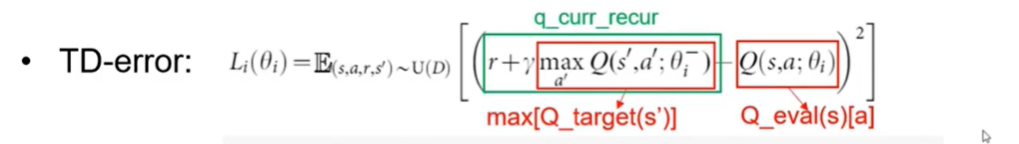



```
self.loss = F.smooth_l1_loss(q_curr_eval, q_curr_recur)
```



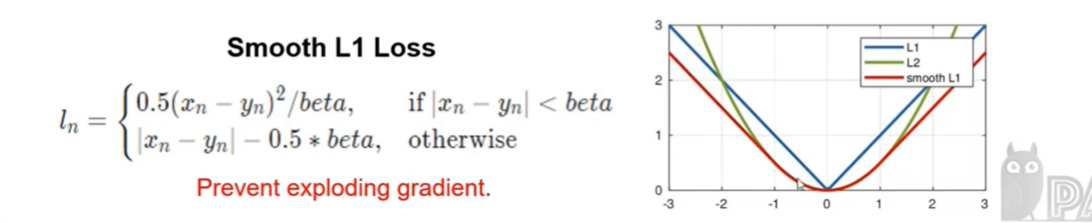

In [ ]:
stack_frames = 4
img_size = (84,84)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

agent = DeepQNetwork(
    n_actions = env.action_space.n,
    input_shape = [stack_frames, *img_size],
    qnet = QNet,
    device = device,
    learning_rate = 2e-4,
    reward_decay = 0.99,
    replace_target_iter = 5000,
    memory_size = 200000,
    batch_size = 32,
    )
print(agent.n_actions)
print(agent.qnet_eval)

4
QNet(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=4, bias=True)
  )
)


#load!

In [ ]:
agent.save_load_model(op="load", path="breakout/gif/save", fname="qnet_50203.pt") #3.

#繼續

In [ ]:
def play(env, agent, stack_frames, img_size):
  # Reset environment.
  state = env.reset()
  img_buffer = [Image.fromarray(state[0]*255)]

  # Initialize information.
  step = 0
  total_reward = 0
  live_now=5

  # One episode.
  while True:
      # Select action.
      if step==0:
        action=1
      else:
        action = agent.choose_action(state)

      # Get next stacked state.
      state_next, reward, ter,tru, info = env.step(action)
      live_num=info[0].get("lives")

      if(live_num!=live_now):
        action=1
        state_next, reward, ter,tru, info = env.step(action)
        live_now=live_num

      if step % 2 == 0:
          img_buffer.append(Image.fromarray(state_next[0]*255))

      state = state_next.copy()
      step += 1
      total_reward += reward
      print('\rStep: {:3d} | Reward: {:.3f} / {:.3f}'\
          .format(step, reward, total_reward), end="")

      if ter or step>40000: ###改次數
          print()
          break

  return img_buffer


In [ ]:
import os
def save_gif(img_buffer, fname, gif_path=os.path.join("breakout/gif/train", "train"+date_new)): #1.
  if not os.path.exists(gif_path):
      os.makedirs(gif_path)
  img_buffer[0].save(os.path.join(gif_path, fname), save_all=True, append_images=img_buffer[1:], duration=1, loop=0)

In [ ]:
# Test Code
img_buffer = play(env_break, agent, stack_frames, img_size)
save_gif(img_buffer, fname="test_"+date_new+".gif") #1.

Step: 196 | Reward: 0.000 / 23.000


In [ ]:
def epsilon_compute(frame_id, epsilon_max=1, epsilon_min=0.1, epsilon_decay=1000000): ##
  return epsilon_min + (epsilon_max - epsilon_min) * np.exp(-frame_id / epsilon_decay)

In [ ]:
frame_ids = np.array(range(1000000))
epsilons = epsilon_compute(frame_ids)
plt.plot(epsilons)
#epsilon curve
"""
    exploration -> 探索 -> 隨機採取random action、但有可能無法收斂
    exploitation -> 開發 -> 收斂到best action、但有可能就只收斂到local minimum

    解決方法:ɛ-Greedy -> 以某個值去決定做exploration還是exploitation
    0-1中一開始設ɛ=1,先exploration,後調整ɛ越接近0做exploitation
"""

In [ ]:
num=0

In [ ]:
def train(env, agent, stack_frames, img_size, save_path="save", max_steps=0):#4.
  total_step =  0
  episode = 0
  max_total_reward=0
  max_score=0

  while True:
    # Reset environment.
    state = env.reset()

    # Initialize information.
    step = 0
    total_reward = 0
    loss = 0
    live_now=5 ###
    max_reward=2
    score=0

    # One episode.
    while True:
      # TODO(Lab-6): Select action.
      epsilon = epsilon_compute(total_step)
      action = agent.choose_action(state, epsilon)
      # Get next stacked state.
      state_next, reward, ter,tru, info = env.step(action)
      live_num=info[0].get("lives") ###

      score+=reward

      if max_reward<reward: ###
        max_reward=reward+1

      if(live_num!=live_now):
        action=1
        state_next, reward,ter,tru, info = env.step(action)
        live_now=live_num
        reward-=1 ###


      # TODO(Lab-7): Train RL model.
      agent.store_transition(state, action, reward, state_next, ter)
      if total_step > 4*agent.batch_size: #蒐集一定步數後才開始訓練
        loss = agent.learn()

      state = state_next.copy()
      step += 1
      total_step += 1
      total_reward += reward

      if total_step % 100 == 0:
          agent.store_png() ####
      if ter:
        agent.store_t_r(score)
        if total_reward>max_total_reward:
          max_total_reward=total_reward

      if ter:
        print('\rEpisode: {:3d} | Step: {:3d} / {:3d} | Reward: {:.3f} / {:.3f} | Loss: {:.3f} | Epsilon: {:.3f}'\
            .format(episode, step, total_step, reward, total_reward, loss, epsilon))
        print("score:",score)

      if total_step % 10000 == 0:
        num=total_step % 100000
        num//=10000
        print("\nSave Model ...")
        agent.save_load_model(op="save", path=os.path.join("breakout/gif/save"), fname="qnet_"+date_new+"_"+str(num)+".pt")
        print("Generate GIF ...")
        img_buffer = play(env, agent, stack_frames, img_size)
        save_gif(img_buffer, "train"+date_new+"_" + str(total_step).zfill(6) + ".gif")
        print("Done !!")
        print("max_score:",max_score)
        agent.plot_loss()
        agent.plot_t_r()


      if ter or step>2000:
        episode += 1
        break

    if max_score<score:
      max_score=score
      print("max_score:",max_score)

    if total_step > max_steps:
      break
  print("max_score:",max_score)

In [ ]:
train(env_break, agent, stack_frames, img_size, save_path=os.path.join("breakout/gif", "save"), max_steps=10000000) #8.

In [ ]:
def drawing(png_date):
    import os
    import numpy as np
    score_path = os.path.join("breakout/gif/save/"+png_date+"/total_re_"+png_date+".npy")
    score=np.load(score_path)
    num=100
    cnt=len(score)
    cnt-=(cnt%num)
    aver_score=[]

    for i in range(0,cnt,num):
        value=0
        for j in range(i,i+num):
            value+=score[j]
        value/=num
        aver_score.append(value)
    x_t_reward=np.array(list(range(len(aver_score))))
    plt.plot(x_t_reward,aver_score, label='Score') ####
    plt.xlabel('Episode') ####
    plt.ylabel('Score')
    plt.title('Score over Episodes')
    plt.legend()
    plt.savefig("breakout/gif/png/"+png_date+".png")
    plt.show()

In [ ]:
drawing("50303")

In [ ]:
agent.save_load_model(op="save", path=os.path.join("breakout/gif/save"), fname="qnet_"+date_new+".pt")
agent.save_load_model(op="load", path="breakout/gif/save/", fname="qnet_"+date_new+".pt") #3.
img_buffer = play(env_break, agent, stack_frames, img_size)
save_gif(img_buffer, "eval_"+date_new+".gif",os.path.join("breakout/gif/eval"))

In [ ]:
agent.plot_loss()

In [ ]:
agent.plot_rewards()

In [ ]:
agent.plot_t_r()

#補跑eval

In [ ]:
agent.save_load_model(op="load", path="/content/drive/MyDrive/gif/save", fname="qnet_32502.pt") #3.
img_buffer = play(env_break, agent, stack_frames, img_size)
save_gif(img_buffer, "eval_32502.gif",os.path.join("/content/drive/MyDrive/gif/eval"))  #, "eval") #10.

float64
Step: 180 | Reward: 0.000 / 40.000
